In [2]:
#importuje wszytskie potrzebne biblioteki w tym biblioteke kwant
import kwant
import numpy as np
import types
import matplotlib.pyplot as plt
      
    
#Obliczenia prowadze sa w jednostkach atomowych e=h=me=1. Tutaj definiuje wspolczynniki konwersji.
def eV2au(energy): #eV -> j.a
    return energy*0.03674932587122423
def nm2au(length): #nm -> j.a
    return length*18.89726133921252
def T2au(length):  #nm -> j.a
    return length*4.254382E-6


# Zdefiniowanie układu

In [19]:
############################################################################################
## W ramach zdefiniowania ukladu musimy zdefiniowac funkcje okreslajace energie potrzebne ##
## do przeskoku do tego samego wezla oraz wezlow sasiadujacych. Robimy to w funkcjach     ##
## onsite() oraz hopping_x() i hopping_y().
############################################################################################

#definicja ukladu do symulacji
def make_system(nw):
    m=nw.m
    dx=nw.dx
    L=nw.L
    W=nw.W
    V0=nw.V0
    sigma = nw.sigma
    x0 = nm2au(L/2)
    y0 = nm2au(W)
    Bz = T2au(2)
    
        

    def magnetic(x0, y0, x1, y1):
        return np.exp(-0.5j*Bz*(x1 - x0)*(y0+y1))
        
    
    
    def potential_v0(x, y):
        return V0*np.exp((-(x-x0)**2 - (y-y0)**2)/(sigma)**2)
    
    
    def potential_B(x1, y1, x2, y2):
        
        
        return np.exp(1j * line_integral(x1, y1, x2, y2) )
    
    def onsite(site):
        (x, y) = site.pos
        t=1.0/(2.0*m*dx*dx)
        return 4*t + potential_v0(x,y)

    def hopping_x(sitei, sitej):
        (xi, yi) = sitei.pos
        (xj, yj) = sitej.pos
        t=1.0/(2.0*m*dx*dx)        
        return -t*magnetic(xi, yi, xj, yj)
    
    def hopping_y(sitei, sitej):
        (xi, yi) = sitei.pos
        (xj, yj) = sitej.pos
        t=1.0/(2.0*m*dx*dx)
        return -t*magnetic(xi, yi, xj, yj)

    # W ramach definicji ukladu kolejno:
    # 1. Definujemy uklad - funkcja kwant.Builder()  
    # 2. Okreslamy geometrie siatki - kwant.lattice.square(dx, norbs=1)
    # 3. Uzupelniamy macierz
    sys = kwant.Builder()  
    lat = kwant.lattice.square(dx, norbs=1)
    sys[(lat(i,j) for i in range(L) for j in range(-W,W))]=onsite
    sys[(kwant.builder.HoppingKind((-1,0), lat, lat))] = hopping_x
    sys[(kwant.builder.HoppingKind((0,-1), lat, lat))] = hopping_y
    
    
    #dolaczam lewy kontakt do naszego ukladu
    lead_left = kwant.Builder(kwant.TranslationalSymmetry((-dx, 0)))    
    lead_left[(lat(0,j) for j in range(-W,W))]=onsite
    lead_left[(kwant.builder.HoppingKind((-1,0), lat, lat))] = hopping_x
    lead_left[(kwant.builder.HoppingKind((0,-1), lat, lat))] = hopping_y
    sys.attach_lead(lead_left)
    
    
    #dolaczam prawy kontakt do naszego ukladu
    lead_right = kwant.Builder(kwant.TranslationalSymmetry((dx, 0)))    
    lead_right[(lat(0,j) for j in range(-W,W))]=onsite
    lead_right[(kwant.builder.HoppingKind((-1,0), lat, lat))] = hopping_x
    lead_right[(kwant.builder.HoppingKind((0,-1), lat, lat))] = hopping_y
    sys.attach_lead(lead_right)
    
    #finalizujemy uklad
    sys = sys.finalized()
    return sys

# Zdefiniowanie funkcji do liczenia transportu

In [20]:
############################################################################################
##       Definiujemy rozne funkcje liczace podstawowe wlasnosci fizyczne                  ##
############################################################################################

#funkcja wyliczajaca relacje dyspersji w kontakcie nr_lead w granicach [-k_max,k_max] z nk punktami
def disperssion(nw, nr_lead, k_max, nk):
    dx=nw.dx
    sys=make_system(nw)
    momenta = np.linspace(-k_max*dx,k_max*dx,nk)
    bands=kwant.physics.Bands(sys.leads[nr_lead])
    energies=[bands(k) for k in momenta]
    return (momenta/dx)*nm2au(1.0), energies

#funkcja liczaca wspolczynnik odbicia oraz wspolczynnik transmisji
def transmission_reflection(nw, E):
    E=eV2au(E)
    sys=make_system(nw)
    smatrix=kwant.smatrix(sys,E) #Zwraca macierz rozpraszania, kanały mody itp
    r=smatrix.transmission(0,0)
    t=smatrix.transmission(1,0)
    return r, t

#funkcja liczaca wspolczynnik transmisji
def transmission(nw, E):
    E=eV2au(E)
    sys=make_system(nw)
    smatrix=kwant.smatrix(sys,E)
    t=smatrix.transmission(1,0)
    return t

#funkcja liczaca konduktacje - uzyto formuly Landauera
def conductance(nw, Emax, ne):
    energies=np.linspace(0,Emax,ne)
    cond=[transmission(nw, E) for E in energies]
    return energies, cond

#funkcja rysujaca funkcje falowa elektronu o energii E wchodzacego do kontaku nr_lead
def wave_function(nw, E, nr_lead):
    E=eV2au(E)
    sys=make_system(nw)
    wave=kwant.wave_function(sys, E)
    density=(abs(wave(nr_lead))**2).sum(axis=0)
    kwant.plotter.map(sys,density)

#funkcja rysujaca dos elektronu o energii E 
def dos(nw, E):
    E=eV2au(E)
    sys=make_system(nw)
    dos=kwant.ldos(sys, E)
    kwant.plotter.map(sys,dos)

#funkcja rysujaca prad elektronu o energii E wchodzacego do kontaku nr_lead w stanie nr_mod
def current(nw, E, nr_lead, nr_mod):
    E=eV2au(E)
    sys=make_system(nw)
    current = kwant.operator.Current(sys).bind()
    psi=kwant.wave_function(sys, E)(nr_lead)
    curr=current(psi[nr_mod])
    kwant.plotter.current(sys,curr)

# Definicja parametru układu

In [33]:
nw = types.SimpleNamespace(\
                     dx=nm2au(1),
                     L=int(200),
                     W=int(40),
                     m=0.014, 
                     V0=eV2au(0.05),
                     sigma=nm2au(20)
                       )

# NASZ UKŁAD

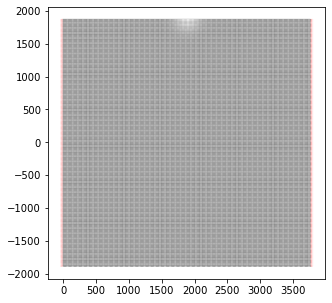

In [22]:
sys=make_system(nw)
kwant.plot(sys, site_color=lambda site: sys.hamiltonian(site,site), fig_size=(10,5), colorbar=False, show=False, num_lead_cells=2);

# Relacje dyspersji w kontakcie

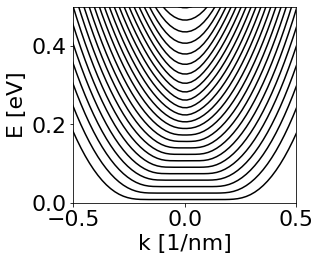

In [32]:
momenta, energies = disperssion(nw, 0, .1, 200)
plt.figure(figsize=(4,4))
plt.plot(momenta, np.asarray(energies)/eV2au(1.0),'k-')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.ylim((0,.5))  
plt.xlim((-0.5,.5))  
plt.xlabel("k [1/nm]",fontsize=22)
plt.ylabel("E [eV]",fontsize=22)
plt.subplots_adjust(bottom=0.2) 
plt.savefig("dyspersja_3.jpg")
plt.show()

# Obliczenia konduktancji

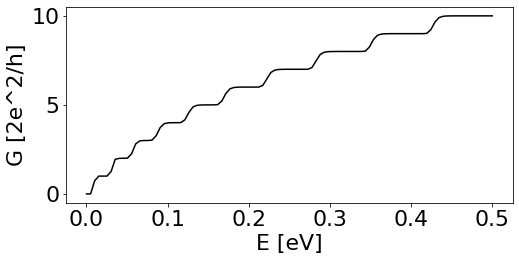

In [34]:
energies, cond=conductance(nw,0.5,100)
plt.figure(figsize=(8,4))
plt.plot(energies, cond,'k-')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xlabel("E [eV]",fontsize=22)
plt.ylabel("G [2e^2/h]",fontsize=22)
plt.subplots_adjust(bottom=0.2) 
plt.savefig("konduktancja2.png")
plt.show()

# Funkcje falowe, DOS i gęstości prądu

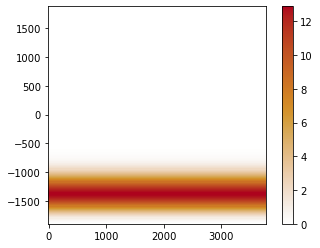

In [30]:
wave_function(nw, 0.01, 1)


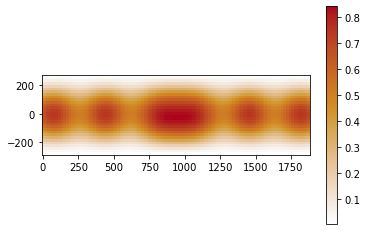

In [69]:
dos(nw, 0.1)

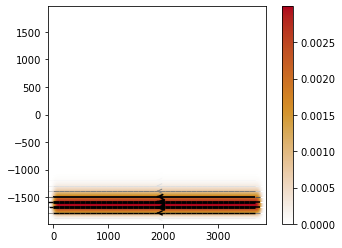

/tmp/ipykernel_7995/3236843697.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.current(sys,curr)


In [29]:
current(nw, 0.1,1,0)